# Word2Vec Skip-Gram Negative Sampling

Word2Vec implementation with Skip-Gram and Negative Sampling.

**NOTE:** This Notebook is based on [this Jupyter notebook](https://github.com/mchablani/deep-learning/blob/master/embeddings/Skip-Gram_word2vec.ipynb) by [Manish Chablani](https://github.com/mchablani).

In [1]:
!pip install nltk

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from typing import *
from pathlib import Path

import random
import zipfile
import nltk
import tensorflow as tf
import pandas as pd
import numpy as np

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
!mkdir -p data
data_dir = Path('data')

## Downloading the text data

Loading the [text8 dataset](http://mattmahoney.net/dc/textdata.html) by Matt Mahoney as our corpus.

In [5]:
!wget -nc http://mattmahoney.net/dc/text8.zip -O data/text8.zip

with zipfile.ZipFile(data_dir / 'text8.zip', 'r') as zip_ref:
    zip_ref.extractall(data_dir)

File `data/text8.zip' already there; not retrieving.


In [6]:
with open(data_dir / 'text8', 'r') as f:
    text = f.read()

## Preprocessing

Preprocessing the data to make training easier.

In [7]:
words = nltk.word_tokenize(text)

In [8]:
print('All Words: {}'.format(len(words)))

All Words: 17007698


In [9]:
# reducing the size of words to mitigate memory issues
words = words[:int(len(words) // 100)]

print('Reduced Words: {}'.format(len(words)))

Reduced Words: 170076


In [10]:
df = pd.DataFrame(words, columns=['word'])

In [11]:
# count all the words
df['count'] = df.groupby('word')['word'].transform('count')

# only keep words which appeared more than 5 times
df = df.loc[df['count'] > 5]

df.head()

,word,count
0,anarchism,104
1,originated,9
2,as,1414
3,a,3074
4,term,68


In [12]:
words = df['word'].values.tolist()

print('Words which appeared more than 5 times: {}'.format(len(words)))

Words which appeared more than 5 times: 145999


In [13]:
lookup_table = df.copy()

# remove duplicate words
lookup_table.drop_duplicates(subset='word', inplace=True)

# sort by count descending
lookup_table.sort_values(by=['count'], ascending=False, inplace=True)

# reset the index
lookup_table.reset_index(drop=True, inplace=True)

lookup_table.head()

,word,count
0,the,10410
1,of,6071
2,and,4723
3,in,3869
4,to,3421


In [14]:
def word_to_pos(word: str) -> int:
    return lookup_table.loc[lookup_table['word'] == word].index[0]

In [15]:
def word_to_count(word: str) -> int:
    return lookup_table.loc[lookup_table['word'] == word]['count'].item()

In [16]:
def pos_to_word(pos: int) -> str:
    return lookup_table['word'][pos]

In [17]:
def pos_to_count(pos: int) -> int:
    return lookup_table.iloc[pos]['count'].item()

In [18]:
word_positions = [word_to_pos(word) for word in words]

In [19]:
word_positions[:10]

[150, 2134, 11, 6, 259, 1, 1498, 61, 78, 220]

## Subsampling

$$P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}$$

$t$ = threshold

$f(w_i)$ = frequency of word $w_i$ in the whole dataset

In [20]:
def p_drop(word_pos: int) -> float:
    thresh = 1e-5
    word_freq = pos_to_count(word_pos)
    res = 1 - np.sqrt(thresh / word_freq)
    return res

In [21]:
word = 'the'
pos = word_to_pos(word)
freq = pos_to_count(pos)

p = p_drop(pos)

print('"{}" appeared {} times and will be dropped with probability {}'.format(word, freq, p))

"the" appeared 10410 times and will be dropped with probability 0.9999690062136313


In [22]:
# train_words = [pos for pos in word_positions if random.random() < (1 - p_drop(pos))]
train_words = [pos for pos in word_positions if random.random() < p_drop(pos)]

In [23]:
print('Training Words: {}'.format(len(train_words)))

Training Words: 145951


## Computing batches

In [24]:
def get_target(words: list, word_pos: int, window_size=5) -> list:
    R = random.randint(1, window_size)
    start = word_pos - R if (word_pos - R) > 0 else 0
    end = word_pos + R + 1
    return list(set(words[start:word_pos] + words[word_pos + 1:end]))

In [25]:
get_target(train_words, 10)

[576, 605, 138, 78, 2521, 1498, 220, 61]

In [26]:
def get_batches(words: list, batch_size: int, window_size=5, debug=False) -> Generator:
    num_batches = len(words) // batch_size
    print('num_bacthes: {}'.format(num_batches)) if debug else None
    # index into words and ensure that only full batches are used
    words = words[:num_batches * batch_size]
    print('len(words): {}'.format(len(words))) if debug else None
    for i in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[i:i + batch_size]
        print('len(batch): {}'.format(len(batch))) if debug else None
        for j in range(len(batch)):
            batch_x = batch[j]
            print('batch_x: {}'.format(batch_x)) if debug else None
            batch_y = get_target(batch, j, window_size)
            print('batch_y: {}'.format(batch_y)) if debug else None
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x, y

In [27]:
gen = get_batches(train_words, 5, 5, True)

In [28]:
x, y = next(gen)

print('x: {}'.format(x))
print('y: {}'.format(y))

num_bacthes: 29190
len(words): 145950
len(batch): 5
batch_x: 150
batch_y: [11, 2134]
batch_x: 2134
batch_y: [259, 11, 150, 6]
batch_x: 11
batch_y: [2134, 6]
batch_x: 6
batch_y: [259, 2134, 11, 150]
batch_x: 259
batch_y: [6]
x: [150, 150, 2134, 2134, 2134, 2134, 11, 11, 6, 6, 6, 6, 259]
y: [11, 2134, 259, 11, 150, 6, 2134, 6, 259, 2134, 11, 150, 6]


## The Graph

In [29]:
graph = tf.Graph()

size_vocab = len(words)
size_embedding = 300
num_sampled = 100

with graph.as_default():
    # inputs and outputs
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, 1], name='labels')
    # the embedding matrix
    embedding = tf.Variable(
        tf.random_uniform((size_vocab, size_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)
    # negative sampling
    softmax_weights = tf.Variable(
        tf.truncated_normal((size_vocab, size_embedding)))
    softmax_biases = tf.Variable(tf.zeros(size_vocab), name='softmax_bias')
    
    loss = tf.nn.sampled_softmax_loss(
        weights=softmax_weights,
        biases=softmax_biases,
        labels=labels,
        inputs=embed,
        num_sampled=num_sampled,
        num_classes=size_vocab)
    
    # define cost and optimizer
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


## Training

In [30]:
epochs = 10
batch_size = 1000
window_size = 10

with tf.Session(graph=graph) as session:
    iteration = 1
    loss = 0
    session.run(tf.global_variables_initializer())

    for epoch in range(1, epochs + 1):
        batches = get_batches(train_words, batch_size, window_size)
        for x, y in batches:
            feed = {inputs: x, labels: np.array(y)[:, None]}
            train_loss, _ = session.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                print("Epoch {}/{}".format(epoch, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. loss: {:.4f}".format(loss / 100))
                loss = 0
            iteration += 1

    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    embed_mat = session.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. loss: 25.0576
Epoch 2/10 Iteration: 200 Avg. loss: 23.9647
Epoch 3/10 Iteration: 300 Avg. loss: 23.0018
Epoch 3/10 Iteration: 400 Avg. loss: 21.9883
Epoch 4/10 Iteration: 500 Avg. loss: 21.1291
Epoch 5/10 Iteration: 600 Avg. loss: 20.1438
Epoch 5/10 Iteration: 700 Avg. loss: 19.3169
Epoch 6/10 Iteration: 800 Avg. loss: 18.4050
Epoch 7/10 Iteration: 900 Avg. loss: 17.5819
Epoch 7/10 Iteration: 1000 Avg. loss: 16.8028
Epoch 8/10 Iteration: 1100 Avg. loss: 16.1122
Epoch 9/10 Iteration: 1200 Avg. loss: 15.4386
Epoch 9/10 Iteration: 1300 Avg. loss: 14.7851
Epoch 10/10 Iteration: 1400 Avg. loss: 14.2354


## Visualization

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [32]:
words_to_visualize = 500

tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:words_to_visualize, :])

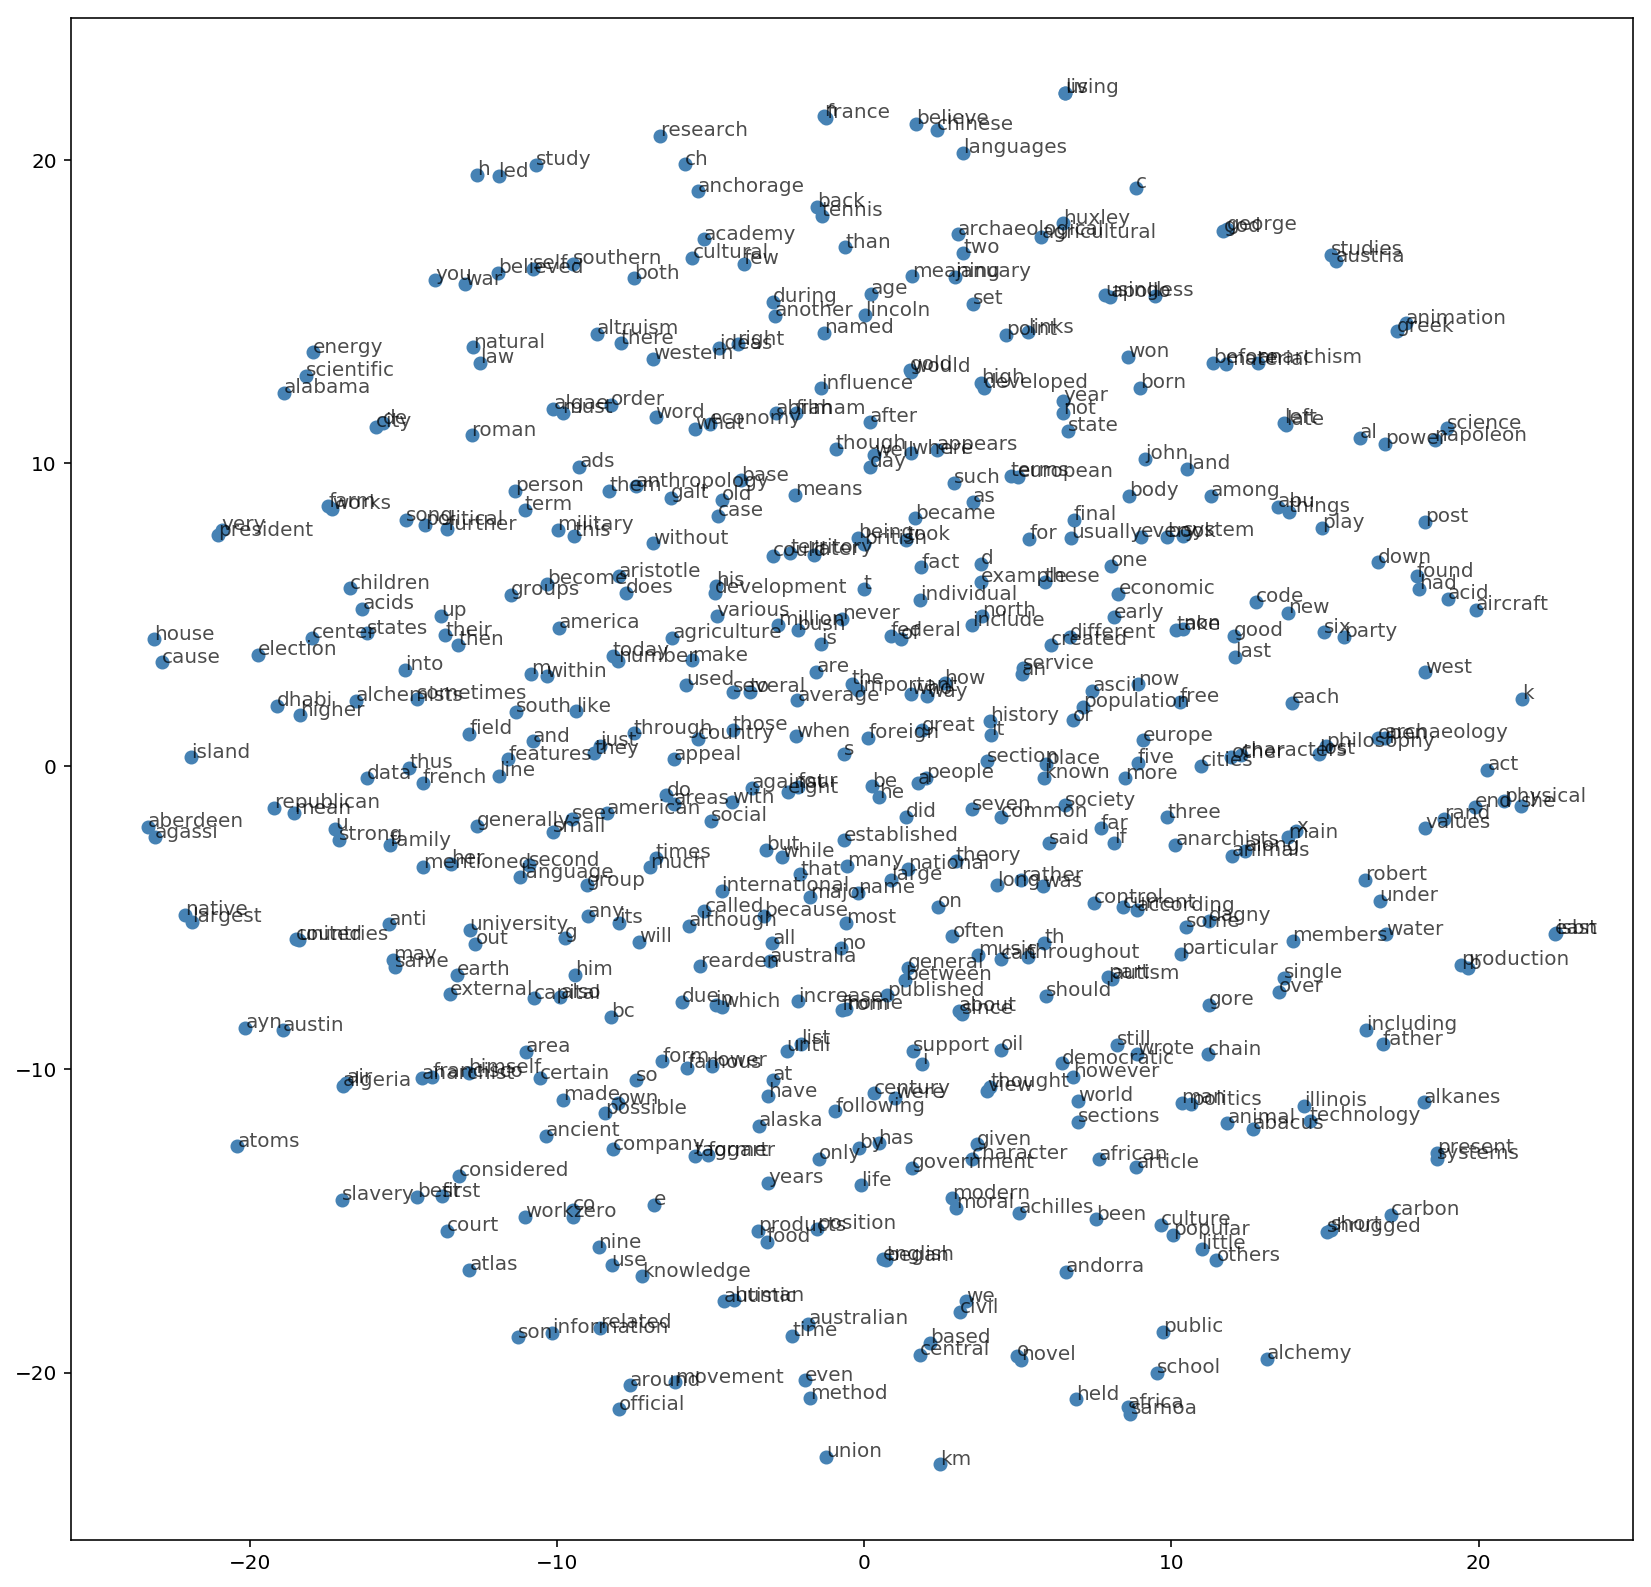

In [33]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(words_to_visualize):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(pos_to_word(idx), (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

## The Lab

You can find more code examples, experiments and tutorials in my GitHub [Lab](https://github.com/pmuens/lab) repository.

## Additional resources

- [Chris McCormick - Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
- [Chris McCormick - Word2Vec Tutorial - Negative Sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/)
- [PyTorch Docs - Word Embeddings](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)
- [d2l.ai - Implementation of Word2vec](https://d2l.ai/chapter_natural-language-processing/word2vec-gluon.html)